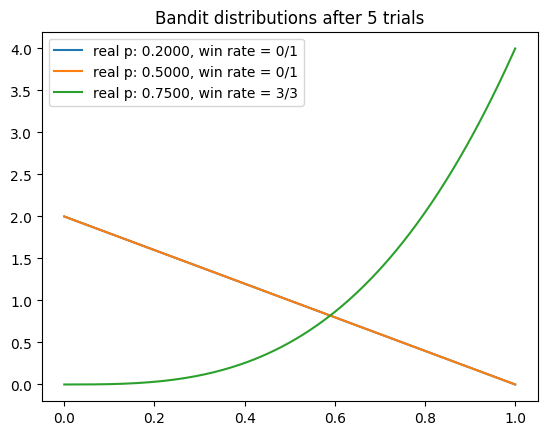

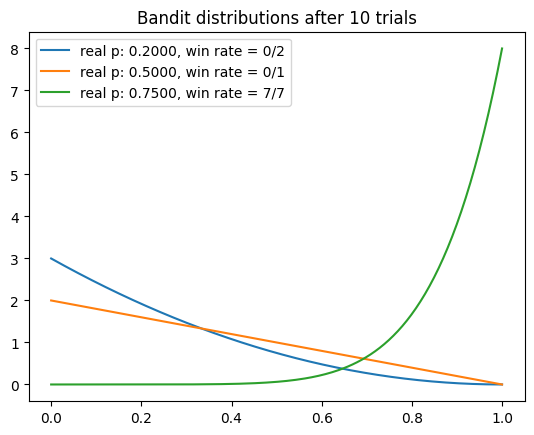

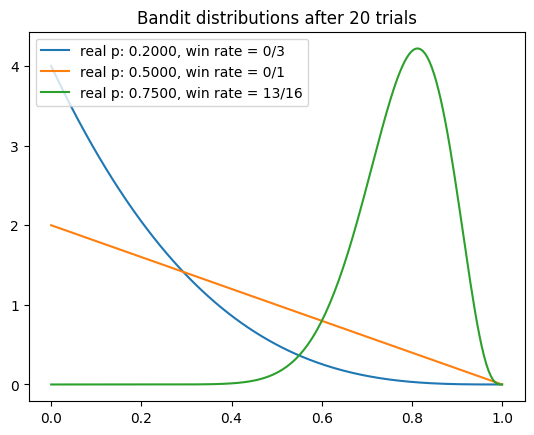

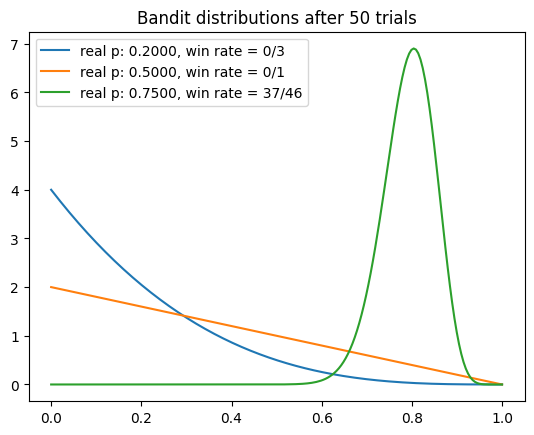

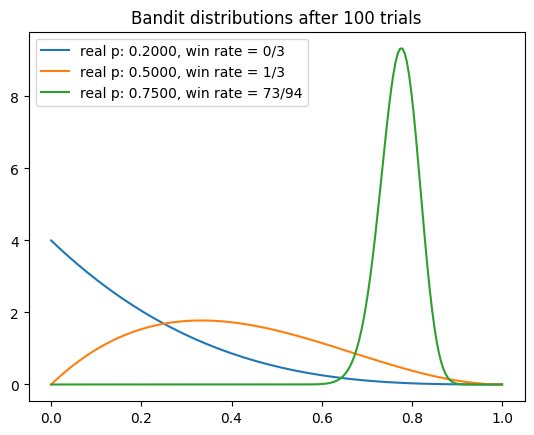

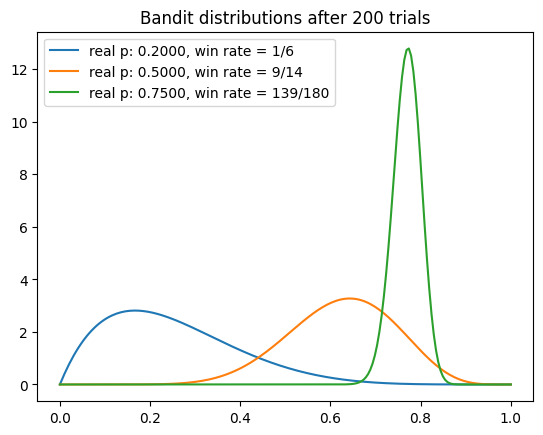

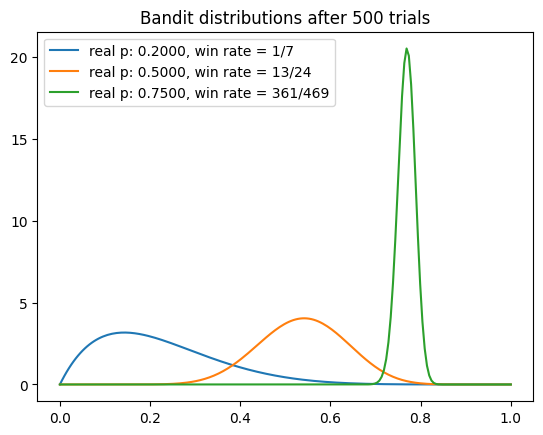

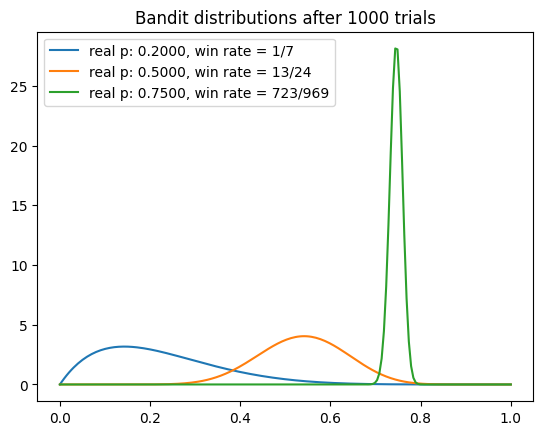

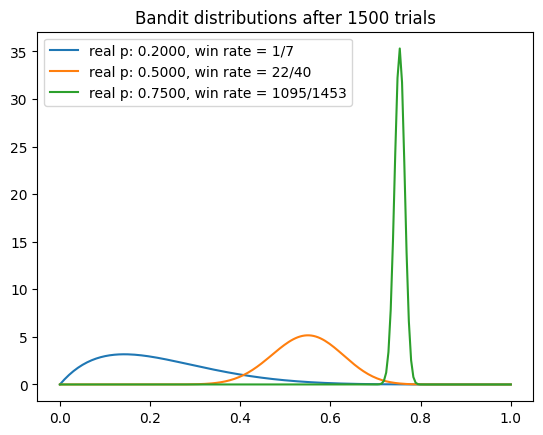

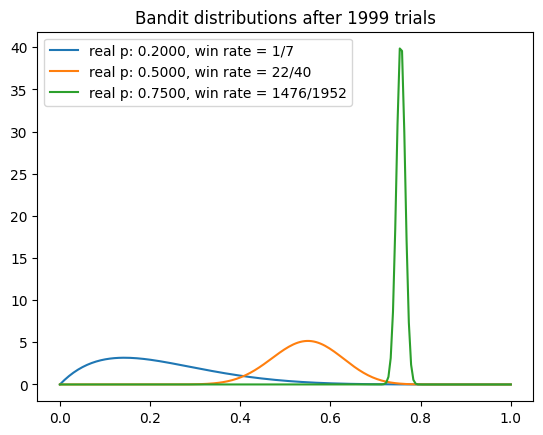

Estimated optimal bandit index (based on means): 2
True optimal bandit index: 2
Mean estimates for each bandit: [0.2222222222222222, 0.5476190476190477, 0.7554987212276215]
Total reward earned: 1499.0
Overall win rate: 0.7495
Number of times selected true optimal bandit: 1953
Number of times selected each bandit: [7, 40, 1953]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


class Bandit:
    def __init__(self, p):
        """
        Initializes a bandit with a given win probability 'p'.

        Attributes:
        - p: The true probability of winning (unknown to the agent).
        - a, b: Parameters of the Beta distribution (initialized to 1 for both, forming a uniform prior).
        - N: Number of times the bandit's arm has been pulled.
        """
        self.p = p
        self.a = 1  # Beta distribution parameter 'a' (alpha), initialized to 1.
        self.b = 1  # Beta distribution parameter 'b' (beta), initialized to 1.
        self.N = 0  # Count of trials (number of times the bandit is pulled).

    def pull(self):
        """
        Simulates pulling the bandit's arm.
        Returns 1 (win) with probability 'p' and 0 (loss) otherwise.
        This is where we simulate the environment's response.
        """
        return np.random.random() < self.p  # Returns True (1) if random < p, simulating a win.

    def sample(self):
        """
        Draws a random sample from the current Beta distribution for Thompson sampling.
        This is used to estimate the bandit's probability of winning based on current knowledge.
        """
        return np.random.beta(self.a, self.b)  # Sample from Beta(a, b).

    def update(self, x):
        """
        Updates the parameters of the Beta distribution based on the outcome of the arm pull.

        Parameters:
        - x: The result of pulling the arm, 1 for win and 0 for loss.

        Updates the distribution with the new evidence (win or loss) and increments the trial count.
        """
        self.a += x  # If win (x=1), increase 'a'.
        self.b += 1 - x  # If loss (x=0), increase 'b'.
        self.N += 1  # Increment the number of trials.


def plot(bandits, trial):
    """
    Plots the current Beta distributions for each bandit.

    Parameters:
    - bandits: List of Bandit objects.
    - trial: The current trial number, used in the plot title.

    Plots the probability density functions of each bandit's Beta distribution to visualize the learning process.
    """
    x = np.linspace(0, 1, 200)  # X-axis values between 0 and 1.
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)  # Beta distribution for current bandit.
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()


def bayesian_bandit_thompson_sampling(bandit_probabilities, num_trials, sample_points=None):
    """
    Runs the Bayesian Bandit Thompson Sampling algorithm to learn the best bandit.

    Parameters:
    - bandit_probabilities: A list of true win probabilities for each bandit.
    - num_trials: The total number of trials (or arm pulls) to simulate.

    The function simulates the bandit problem over a given number of trials, using Thompson Sampling to balance
    exploration and exploitation. It updates the beliefs about each bandit's probability of winning using
    Bayesian inference and plots the evolving distributions at certain checkpoints.
    """
    bandits = [Bandit(p) for p in bandit_probabilities]  # Initialize bandits with true probabilities.
    rewards = np.empty(num_trials)  # Array to store rewards for each trial.
    if sample_points is None:
        # Default points at which to plot the distributions, if none are provided.
        sample_points = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, 1999]
    optimal_j = np.argmax(bandit_probabilities)  # Index of the true optimal bandit.
    num_optimal = 0  # Counter for the number of times the true optimal bandit is selected.

    # Main loop: Play the bandits using Thompson Sampling over the given number of trials.
    for i in range(num_trials):
        # Thompson sampling: Sample from each bandit's Beta distribution and choose the one with the largest sample.
        j = np.argmax([b.sample() for b in bandits])

        # Plot the posterior distributions at certain points during the simulation.
        if i in sample_points:
            plot(bandits, i)

        # Pull the chosen bandit's arm and get a reward.
        x = bandits[j].pull()

        # Update the reward history and the bandit's distribution.
        rewards[i] = x
        bandits[j].update(x)

        # Check if the chosen bandit is the true optimal bandit.
        if j == optimal_j:
            num_optimal += 1

    # Compute statistics for the experiment.
    total_reward = rewards.sum()  # Total reward earned over all trials.
    overall_win_rate = total_reward / num_trials  # Overall win rate (reward per trial).

    # Estimate the optimal bandit based on the means of the Beta distributions.
    mean_estimates = [b.a / (b.a + b.b) for b in bandits]  # Mean of the Beta distribution (a / (a + b)).
    estimated_optimal_bandit_index = np.argmax(mean_estimates)

    # Print out experiment results.
    print("Estimated optimal bandit index (based on means):", estimated_optimal_bandit_index)
    print("True optimal bandit index:", optimal_j)
    print("Mean estimates for each bandit:", mean_estimates)
    print("Total reward earned:", total_reward)
    print("Overall win rate:", overall_win_rate)
    print("Number of times selected true optimal bandit:", num_optimal)
    print("Number of times selected each bandit:", [int(b.N) for b in bandits])


if __name__ == "__main__":
    BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]  # The true win probabilities of each bandit.
    NUM_TRIALS = 2000  # Number of trials to simulate.
    bayesian_bandit_thompson_sampling(BANDIT_PROBABILITIES, NUM_TRIALS)